### [Parallel Ensemble Simulations](https://docs.sciml.ai/dev/features/ensemble/)

In [1]:
using Distributed
using DifferentialEquations
using Plots
using DifferentialEquations.EnsembleAnalysis

#### Example 1: Solving an ODE With Different Initial Conditions

In [2]:
# addprocs()
# @everywhere using DifferentialEquations

In [3]:
# Linear ODE which starts at 0.5 and solves from t=0.0 to t=1.0
prob = ODEProblem((u, p, t)->1.01u,0.5, (0.0, 10.0))

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: 0.5

In [4]:
function prob_func(prob, i, repeat)
  remake(prob,u0=rand() * prob.u0)
end

prob_func (generic function with 1 method)

to use `EnsembleThreads`
use 
`export JULIA_NUM_THREADS=4`
in terminal.

In [5]:
ensemble_prob = EnsembleProblem(prob,prob_func=prob_func)
sim = solve(ensemble_prob,
            Tsit5(),
#             EnsembleDistributed(),
            EnsembleThreads(),
            trajectories=5,
            saveat=0.1);

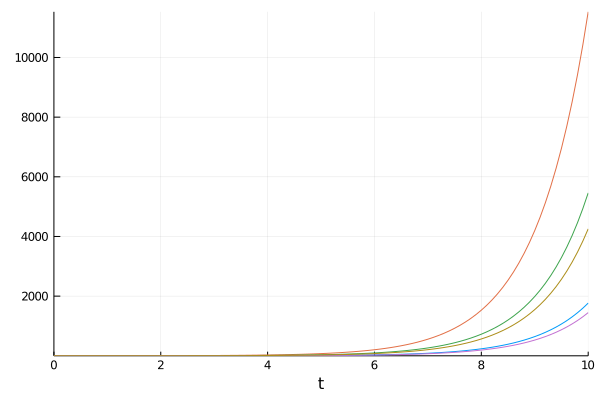

In [6]:
# plotly()
plot(sim, linealpha=1)

In [7]:
# println(typeof(sim.u))
println(length(sim.u))
println(length(sim.u[1]))

5
101


In [8]:
# get_timestep(sim,1)
# get_timepoint(sim, 0.5)
timestep_mean(sim,1)

0.20100867946339082

In [9]:
a = timeseries_steps_mean(sim);
println(length(a.t), " ", length(a.u))

101 101


#### Pre-Determined Initial Conditions

In [10]:
# initial_conditions = range(0, stop=1, length=10);
# function prob_func(prob,i,repeat)
#   remake(prob,u0=initial_conditions[i])
# end

#### Example 2: Solving an SDE with Different Parameters

In [11]:
function f(du,u,p,t)
  du[1] = p[1] * u[1] - p[2] * u[1]*u[2]
  du[2] = -3 * u[2] + u[1]*u[2]
end

function g(du,u,p,t)
  du[1] = p[3]*u[1]
  du[2] = p[4]*u[2]
end

p = [1.5, 1.0, 0.1, 0.1]
prob = SDEProblem(f, 
                  g, 
                  [1.0, 1.0],
                  (0.0, 10.0),
                  p);

keep the same parameters in the deterministic component each time, but vary the parameters for the amount of noise using `0.3rand(2)` as our parameters. We modify the parameters in `prob.p`:

In [12]:
function prob_func(prob, i, repeat)
  x = 0.3rand(2)
  remake(prob, p=[p[1:2]; x])
    end;

In [13]:
# [[1.,2.]; 0.3rand(2)]

In [14]:
ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
sim = solve(ensemble_prob, SRIW1(), trajectories=10);

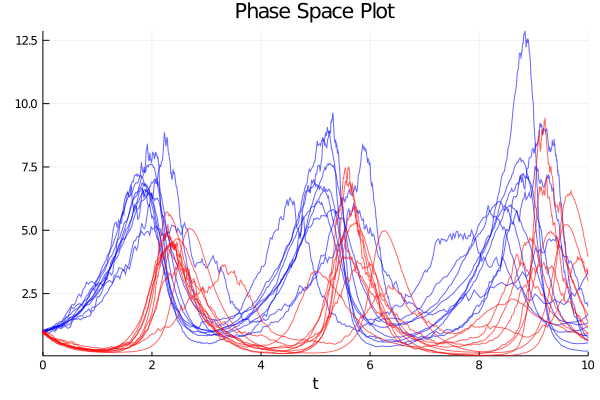

In [15]:
plot(sim, linealpha=0.6, color=:blue, vars=(0, 1))
plot!(sim, linealpha=0.6, color=:red, vars=(0, 2),
      title="Phase Space Plot")

In [16]:
summ = EnsembleSummary(sim, 0:0.1:10)
# Note that plotly does not support ribbon plots
# using PyPlot;
# pyplot()
# plot(summ, fillalpha=0.5)
# https://docs.juliaplots.org/latest/generated/pyplot/

In [17]:
# x = rand(10)
# p1 = plot(x, title = "Default looks")
# p2 = plot(x, grid = (:y, :olivedrab, :dot, 1, 0.9), title = "Modified y grid")
# p3 = plot(deepcopy(p2), title = "Add x grid")
# xgrid!(p3, :on, :cadetblue, 2, :dashdot, 0.4)
# plot(p1, p2, p3, layout = (1, 3), label = "", fillrange = 0, fillalpha = 0.3)

In [7]:
function f(du,u,p,t)
  du[1] = p[1] * u[1] - p[2] * u[1]*u[2]
  du[2] = -3 * u[2] + u[1]*u[2]
end

function g(du,u,p,t)
  du[1] = p[3]*u[1]
  du[2] = p[4]*u[2]
end

p = [1.5, 1.0, 0.1, 0.1]
prob = SDEProblem(f, 
                  g, 
                  [1.0, 1.0],
                  (0.0, 10.0),
                  p);
function prob_func(prob, i, repeat)
  remake(prob, u0=[rand() * prob.u0[i] for i=1:2])
    end;
ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
sim = solve(ensemble_prob, SRIW1(), trajectories=10);

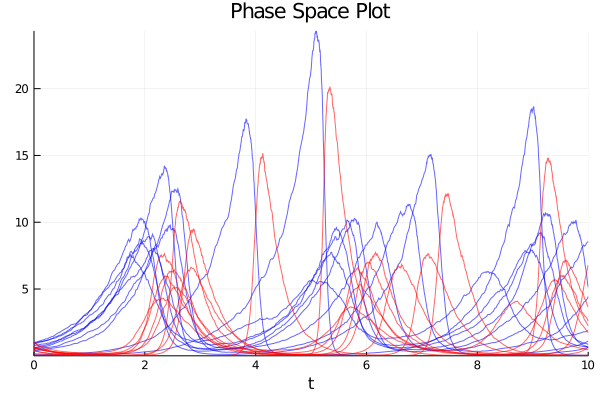

In [8]:
plot(sim, linealpha=0.6, color=:blue, vars=(0, 1))
plot!(sim, linealpha=0.6, color=:red, vars=(0, 2),
      title="Phase Space Plot")